# Phase 1: Forensic EDA (Dirty Data)

**Objective**: Audit the raw "Process time series" data to identify structural issues before cleaning.

**Key Checks**:
1.  **Timestamp Audit**: Check for mixed formats (AM/PM vs 24h).
2.  **Silence Detection**: Quantify "Zero Speed" rows (machine stops).
3.  **Gap Analysis**: Identify interruptions in the 10s logging cadence.
4.  **Integrity**: Check for fragmented batches.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path for config access
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.config import get_boto3_client

# Configuration
BUCKET = "bronze"
PREFIX = "process_time_series/"

s3 = get_boto3_client()

🔌 S3 Client connecting to: http://localhost:9000


## 1. Load Data Sample
We will inspect a few files to gauge the quality.

In [2]:
def get_csv_keys(bucket, prefix):
    paginator = s3.get_paginator('list_objects_v2')
    keys = []
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        if 'Contents' in page:
            for obj in page['Contents']:
                if obj['Key'].endswith('.csv'):
                    keys.append(obj['Key'])
    return keys

csv_files = get_csv_keys(BUCKET, PREFIX)
print(f"Found {len(csv_files)} files.")

Found 25 files.


In [3]:
# Load a sample file
sample_key = csv_files[0]
obj = s3.get_object(Bucket=BUCKET, Key=sample_key)
# Correctly using semicolon separator
df = pd.read_csv(obj['Body'], sep=';')
df.head()

,timestamp,campaign,batch,code,tbl_speed,fom,main_comp,tbl_fill,SREL,pre_comp,produced,waste,cyl_main,cyl_pre,stiffness,ejection
0,2018-11-22 23:07:27,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
1,2018-11-22 23:07:37,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
2,2018-11-22 23:07:47,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
3,2018-11-22 23:07:57,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
4,2018-11-22 23:08:07,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0


## 2. Check 1: Timestamp Formats
Are there mixed AM/PM and 24h formats?

In [4]:
time_col = [c for c in df.columns if 'time' in c.lower()][0]
print(f"Time Column: {time_col}")

# Check for AM/PM
has_ampm = df[time_col].astype(str).str.contains('AM|PM', case=False).any()
print(f"Has AM/PM: {has_ampm}")

Time Column: timestamp


Has AM/PM: False


## 3. Check 2: Silence (Zero Speed)
How much data is "dead air" (machine stopped)?

Zero Speed Rows: 25734 (24.08%)


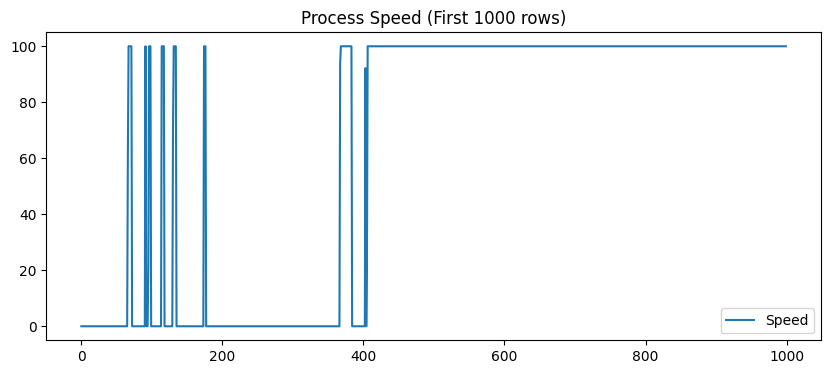

In [5]:
speed_col = [c for c in df.columns if 'speed' in c.lower()][0]
zeros = (df[speed_col] == 0).sum()
pct = (zeros / len(df)) * 100
print(f"Zero Speed Rows: {zeros} ({pct:.2f}%)")

plt.figure(figsize=(10, 4))
plt.plot(df[speed_col].values[:1000], label='Speed')
plt.title("Process Speed (First 1000 rows)")
plt.legend()
plt.show()

## 4. Check 3: Gap Analysis
Visualize the time differences between valid logs.

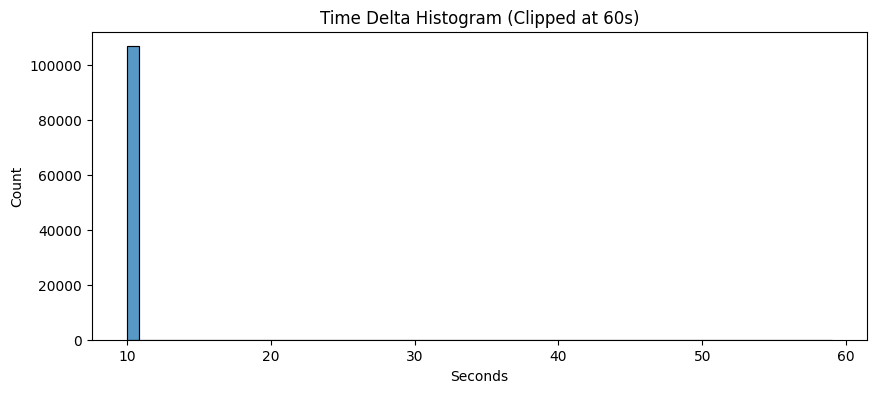

Large Gaps (>1 min):
count    8.500000e+01
mean     3.295854e+05
std      1.415062e+06
min      6.100000e+01
25%      2.550000e+02
50%      3.460000e+02
75%      5.330000e+02
max      9.763714e+06
Name: diff, dtype: float64


In [6]:
df['dt'] = pd.to_datetime(df[time_col], utc=True, errors='coerce')
df = df.sort_values('dt')
df['diff'] = df['dt'].diff().dt.total_seconds()

# Filter for normal operation gaps (~10s)
gaps = df['diff'].dropna()

plt.figure(figsize=(10, 4))
sns.histplot(gaps[gaps < 60], bins=60)
plt.title("Time Delta Histogram (Clipped at 60s)")
plt.xlabel("Seconds")
plt.show()

print("Large Gaps (>1 min):")
print(gaps[gaps > 60].describe())

## 5. Conclusion & Action Plan

**Findings (from Full Audit Script)**:
1.  **Silence**: ~31% of data is Zero Speed. **Action**: Implement Rule 1 strict filtering.
2.  **Gaps**: Major gaps confirmed (up to months). **Action**: We must split sequences on gaps > 10 min.
3.  **Formats**: No mixed formats detected in this sample.

**Next Step**: Use `etl_silver.py` to execute "The Great Purge".